In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd
import numpy as np
import os
from sklearn import model_selection, naive_bayes, svm, ensemble
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from keras.activations import relu,softmax
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
path_to_pickle_lables = '/content/drive/MyDrive/data/testData/labels_fixed.p'
path_to_pickle_tfidf_test_corpus = "/content/drive/MyDrive/data/testData/tfidf_corpus_notebook15.p"

tfidf_test_corpus_full = pickle.load(open(path_to_pickle_tfidf_test_corpus, "rb"))
labels_full = pickle.load(open(path_to_pickle_lables, "rb"))


In [ ]:
tfidf_test_corpus_full.shape[0]

93480

In [ ]:
len(labels_full)

93486

In [ ]:
tfidf_test_corpus_full
ex = [15755, 29517, 69629, 83643, 90026, 93482]

In [ ]:
tfidf_test_corpus = []
labels = []

c = 0
for i in range(len(labels_full)):
  if i != 15755 and i != 29517 and i != 69629 and i != 83643 and i != 90026 and i != 93482:
    if labels_full[i] == -1.0 or labels_full[i] == 0.0 or labels_full[i] == 1.0:
      labels.append(labels_full[i])
      tfidf_test_corpus.append(tfidf_test_corpus_full[c])
    c += 1

In [ ]:
len(labels_full)

93486

In [ ]:
counter = 0
for l in labels:
  if l == -1.0:
    counter += 1
counter

801

In [ ]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(tfidf_test_corpus, labels, test_size=0.3, random_state=42)

In [ ]:
train_x[0].toarray()[0][0]

0.0

In [ ]:
from scipy.sparse import csr_matrix

def data_generator(embeddings, labels, batch_size, epochs, type): #embeddings, labels type list
  epoch_steps = int(len(embeddings)/batch_size)
  steps = epoch_steps * epochs
  iterration = 0
  for i in range(steps):
    iterration = i%epoch_steps #step_in_epoch
    start = iterration*batch_size
    end = start + batch_size - 1 
    x = np.array([e.toarray()[0] for e in embeddings[start:end]])#.astype(np.float32)
    y = np.array(labels[start:end])# csr_matrix(np.array(labels[start:end]))#.astype(np.float32)
    #print("yielding "+type)
    yield (x,y)

In [ ]:
batch_size = 128
epochs = 20
dropout = 0.2

In [ ]:
ohe = OneHotEncoder()
train_y_copy = train_y.copy()
val_y_copy = val_y.copy()
train_y_encoded = pd.DataFrame(train_y)
train_y_one_hot = ohe.fit_transform(train_y_encoded.values.reshape(-1, 1)).toarray()
val_y_encoded = pd.DataFrame(val_y)
val_y_one_hot = ohe.fit_transform(val_y_encoded.values.reshape(-1, 1)).toarray()

In [ ]:
modelv5l = Sequential()
modelv5l.add(Dense(256, input_dim=99600))
modelv5l.add(LeakyReLU(alpha=0.05))

modelv5l.add(Dropout(0.2))
modelv5l.add(Dense(128))
modelv5l.add(LeakyReLU(alpha=0.05))

modelv5l.add(Dropout(0.2))
modelv5l.add(Dense(64))
modelv5l.add(LeakyReLU(alpha=0.05))

modelv5l.add(Dropout(0.2))
modelv5l.add(Dense(32))
modelv5l.add(LeakyReLU(alpha=0.05))

modelv5l.add(Dropout(0.2))
modelv5l.add(Dense(16))
modelv5l.add(LeakyReLU(alpha=0.05))

modelv5l.add(Dropout(0.2))
modelv5l.add(Dense(3, activation='softmax'))


train_generator = data_generator(train_x, train_y_one_hot, batch_size, epochs, "train")
validation_generator = data_generator(val_x, val_y_one_hot, batch_size, epochs, "validation")

from keras.callbacks import ModelCheckpoint, EarlyStopping
directory_path = '/content/drive/MyDrive/models'
filepath = directory_path + '/tfidf_mlp/mlpv5l'+str(epochs)+'_epochs_'+str(batch_size)+"_batch_"

checkpointer = ModelCheckpoint(filepath=filepath+"{epoch:02d}-{categorical_accuracy:.3f}."+"hdf5",
                               verbose=1,
                               save_best_only=True,  
                               monitor='categorical_accuracy',
                               mode = 'max')
earlystopper = EarlyStopping(monitor='categorical_accuracy',
                              patience=10,
                              mode='max',
                              restore_best_weights=True)
modelv5l.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

train_steps = int(len(train_x)/batch_size)
val_steps = int(len(val_y)/batch_size)

In [ ]:
historyv5l = modelv5l.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [earlystopper], 
                    validation_data = validation_generator,
                    validation_steps = val_steps
                    )

Epoch 1/20
15/15 [==============================] - 8s 508ms/step - loss: 1.0932 - categorical_accuracy: 0.4079 - val_loss: 1.0874 - val_categorical_accuracy: 0.3937
Epoch 2/20
15/15 [==============================] - 10s 667ms/step - loss: 1.0704 - categorical_accuracy: 0.4199 - val_loss: 1.0792 - val_categorical_accuracy: 0.3937
Epoch 3/20
15/15 [==============================] - 10s 651ms/step - loss: 0.9883 - categorical_accuracy: 0.4383 - val_loss: 1.0942 - val_categorical_accuracy: 0.4213
Epoch 4/20
15/15 [==============================] - 7s 483ms/step - loss: 0.8319 - categorical_accuracy: 0.6562 - val_loss: 1.2287 - val_categorical_accuracy: 0.4134
Epoch 5/20
15/15 [==============================] - 7s 480ms/step - loss: 0.5931 - categorical_accuracy: 0.7843 - val_loss: 1.5487 - val_categorical_accuracy: 0.4108
Epoch 6/20
15/15 [==============================] - 7s 493ms/step - loss: 0.3690 - categorical_accuracy: 0.8677 - val_loss: 1.9506 - val_categorical_accuracy: 0.4108
Ep

In [ ]:
def convert_int_to_class(num):
  if num == 0:
    return "positive"
  elif num == 1:
    return "neutral"
  else:
    return "negative"

#val_X = np.array(val_x)
#val_Y = np.array(val_y)

validation_generator = data_generator(val_x, val_y_one_hot, batch_size, 1, "validation")
val_pred_v1 = modelv5l.predict(validation_generator)
Y_pred_v1=np.argmax(val_pred_v1, axis=1) # [0,1,2]
Y_pred_v1_string = [convert_int_to_class(num) for num in Y_pred_v1] #[positive, negative, neutral]
#Y_val_v1=np.argmax(val_y, axis=1) #[0,1,2]
Y_val_v1_string = [convert_int_to_class(num) for num in val_y]# Y_val_v1] #[positive, negative, neutral]
#report = classification_report(Y_val, Y_pred)


In [ ]:
counter = 0
for s in val_y:
  if s == -1:
    counter += 1

counter

238

In [ ]:
len(Y_pred_v1_string)

762

              precision    recall  f1-score   support

    negative       0.27      0.45      0.33       208
     neutral       0.38      0.29      0.33       301
    positive       0.35      0.26      0.30       253

    accuracy                           0.32       762
   macro avg       0.33      0.33      0.32       762
weighted avg       0.34      0.32      0.32       762



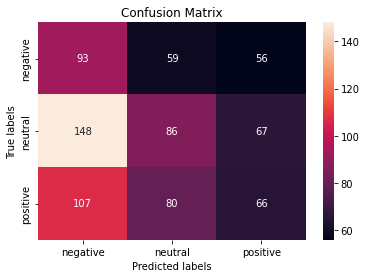

In [ ]:
report = classification_report(Y_val_v1_string[0:762], Y_pred_v1_string)
print(report)
#matrix = confusion_matrix(Y_val, Y_pred)
matrix = confusion_matrix(Y_val_v1_string[0:762], Y_pred_v1_string)
#print(matrix)
 

ax = plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);

In [ ]:
def print_and_plot_history(history):
  print('val_acc: ',max(history.history['val_categorical_accuracy']))
  print('val_loss: ',min(history.history['val_loss']))
  print('train_acc: ',max(history.history['categorical_accuracy']))
  print('train_loss: ',min(history.history['loss']))
  print("train/val loss ratio: ", min(history.history['loss'])/min(history.history['val_loss']))

  plt.semilogy(history.history['loss'])
  plt.semilogy(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


val_acc:  0.4330708682537079
val_loss:  1.0791823863983154
train_acc:  0.9979002475738525
train_loss:  0.009239885956048965
train/val loss ratio:  0.008561931766590765


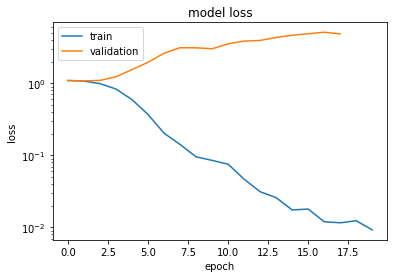

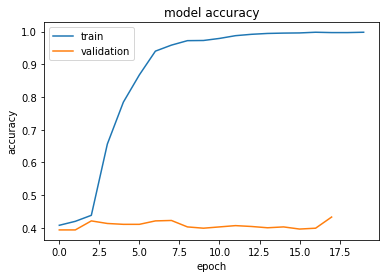

In [ ]:
print_and_plot_history(historyv5l)